# Задание 1

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.patches
from sklearn.linear_model import LinearRegression
from matplotlib import rcParams

In [17]:
plot_w = 13
plot_h = 7
rcParams['figure.figsize'] = plot_w, plot_h
davis_df = pd.read_csv("C:\\Users\\firda\\Desktop\\ML\\Laba 2\\Davis.csv")
davis_df

,Unnamed: 0,sex,weight,height,repwt,repht
0,1,M,77,182,77.0,180.0
1,2,F,58,161,51.0,159.0
2,3,F,53,161,54.0,158.0
3,4,M,68,177,70.0,175.0
4,5,F,59,157,59.0,155.0
...,...,...,...,...,...,...
195,196,M,74,175,71.0,175.0
196,197,M,83,180,80.0,180.0
197,198,M,81,175,NaN,NaN
198,199,M,90,181,91.0,178.0


Пропорции мужчин в датасете

In [80]:
def male_proportion(df):
    df.groupby([df.sex == "M"]).count()
    M_count = len(df[df.sex == "M"].index)
    return M_count / len(df.index)

male_proportion(davis_df)

0.44

Выбросы

Text(0, 0.5, 'weight')

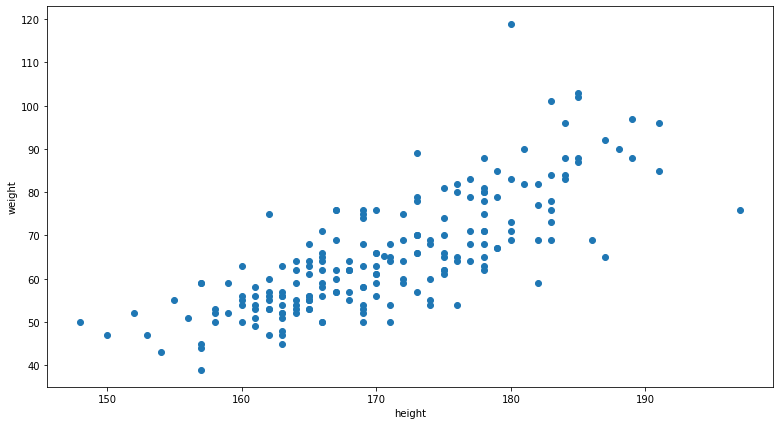

In [81]:
plt.scatter(x=davis_df["height"], y=davis_df["weight"])
plt.xlabel("height")
plt.ylabel("weight")

Text(0, 0.5, 'repwt')

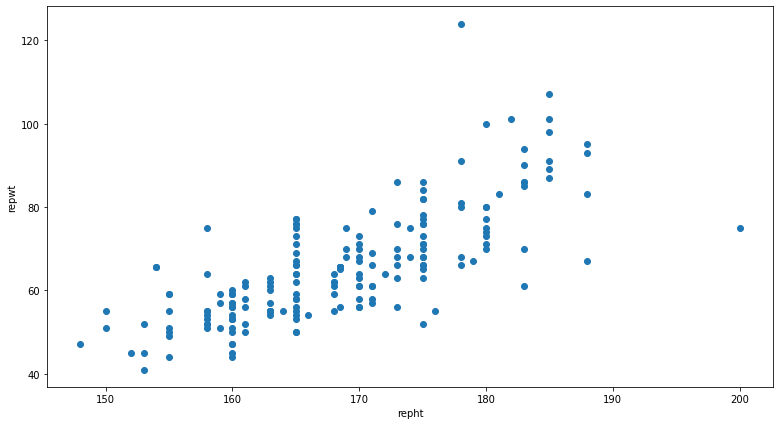

In [82]:
plt.scatter(x=davis_df["repht"], y=davis_df["repwt"])
plt.xlabel("repht")
plt.ylabel("repwt")

Text(0, 0.5, 'weight')

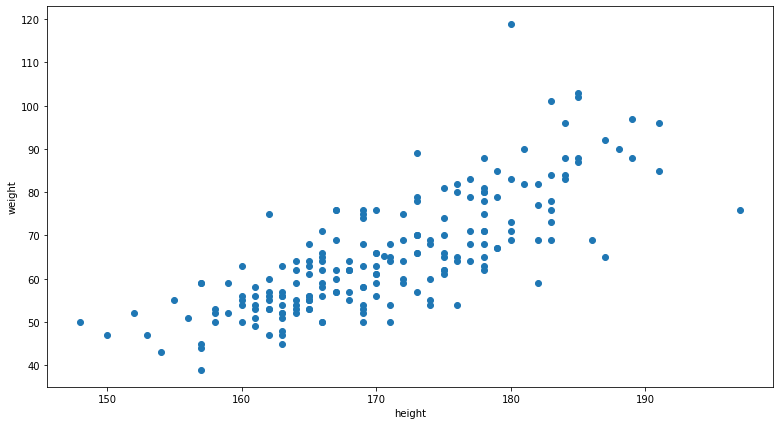

In [83]:
davis_df.where(davis_df["height"] > 100, inplace=True)
davis_df.fillna(davis_df.mean(), inplace=True)
plt.scatter(x=davis_df["height"], y=davis_df["weight"])
plt.xlabel("height")
plt.ylabel("weight")

Разделение датасета на 2 выборки (train, test) из 100 человек, с сохранением пропорции полов.

In [84]:
male_proportion(davis_df)

0.44

In [85]:
male_davis_df = davis_df[davis_df.sex == "M"]
female_davis_df = davis_df[davis_df.sex == "F"]
train_davis_df = male_davis_df.sample(frac=0.5).append(female_davis_df.sample(frac=0.5))
test_davis_df = pd.concat([davis_df, train_davis_df]).drop_duplicates(keep=False)
male_proportion(train_davis_df), male_proportion(test_davis_df)

(0.44, 0.44)

Отображение train-выборки в виде точек на графике

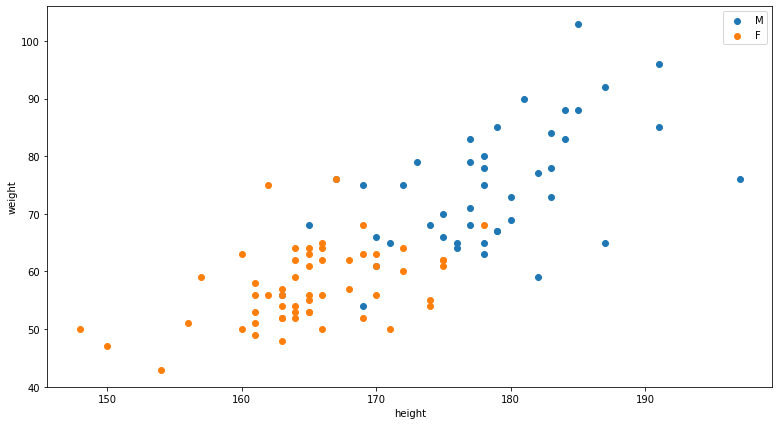

In [86]:
plt.scatter(x=train_davis_df.where(train_davis_df["sex"] == "M")["height"],
            y=train_davis_df.where(train_davis_df["sex"] == "M")["weight"], label="M")
plt.scatter(x=train_davis_df.where(train_davis_df["sex"] == "F")["height"],
            y=train_davis_df.where(train_davis_df["sex"] == "F")["weight"], label="F")
plt.xlabel("height")
plt.ylabel("weight")
plt.legend()

Общая гистограмма роста и веса

Text(0.5, 0, 'weight')

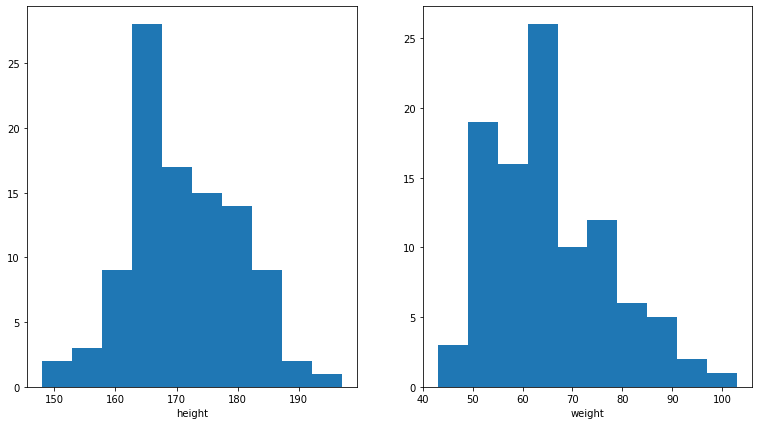

In [87]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df["height"])
ax[0].set_xlabel("height")
ax[1].hist(train_davis_df["weight"])
ax[1].set_xlabel("weight")

Гистограмма роста и веса мужчин

Text(0.5, 0, 'weight')

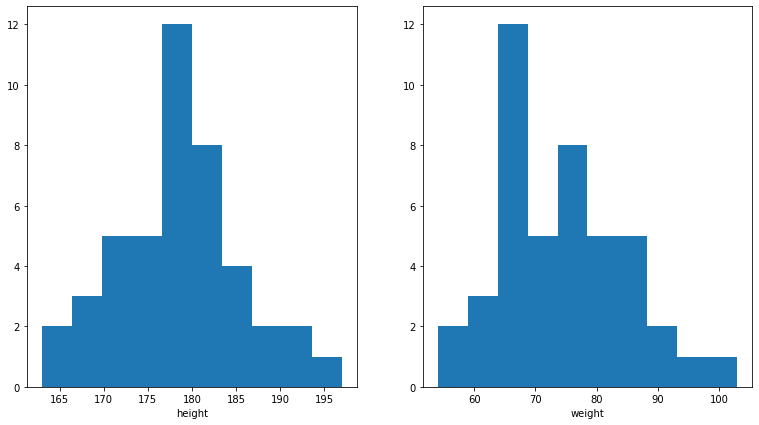

In [88]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df.where(train_davis_df["sex"]=="M")["height"])
ax[0].set_xlabel("height")
ax[1].hist(train_davis_df.where(train_davis_df["sex"]=="M")["weight"])
ax[1].set_xlabel("weight")

Гистограмма роста и веса женщин

Text(0.5, 0, 'weight')

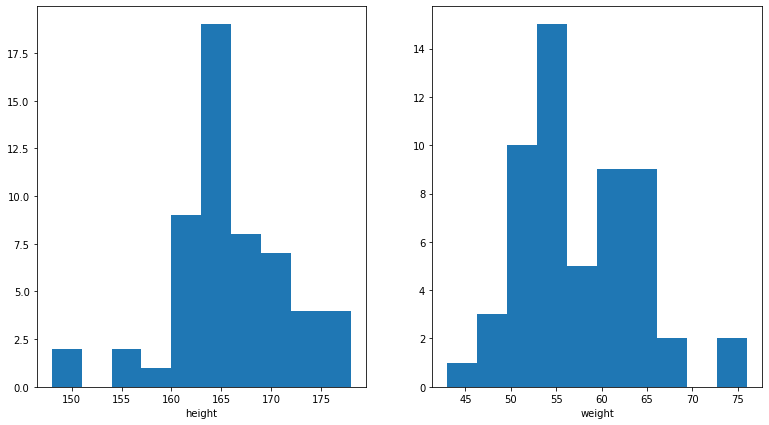

In [89]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df.where(train_davis_df["sex"]=="F")["height"])
ax[0].set_xlabel("height")
ax[1].hist(train_davis_df.where(train_davis_df["sex"]=="F")["weight"])
ax[1].set_xlabel("weight")

Общие величины (repwt - weight)

Text(0.5, 0, 'repht - height')

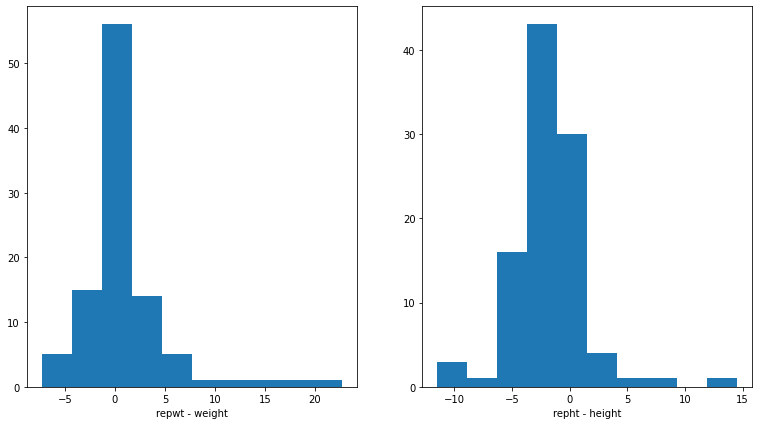

In [90]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df["repwt"] - train_davis_df["weight"])
ax[0].set_xlabel("repwt - weight")
ax[1].hist(train_davis_df["repht"] - train_davis_df["height"])
ax[1].set_xlabel("repht - height")

Величины (repwt - weight) мужчин

Text(0.5, 0, 'repht - height')

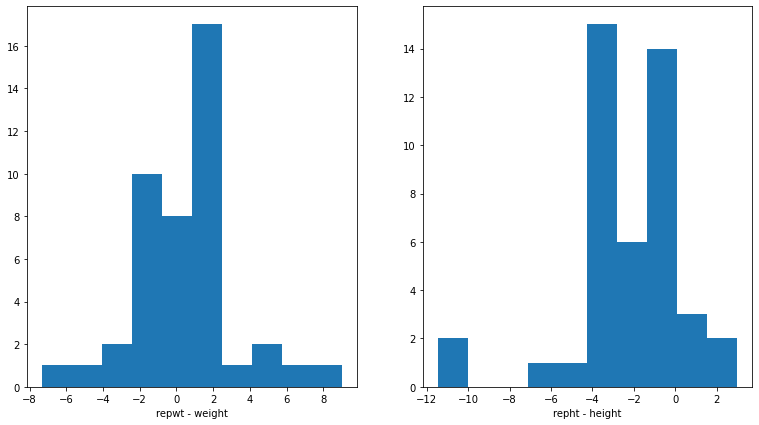

In [91]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df.where(train_davis_df["sex"]=="M")["repwt"] - train_davis_df.where(train_davis_df["sex"]=="M")["weight"])
ax[0].set_xlabel("repwt - weight")
ax[1].hist(train_davis_df.where(train_davis_df["sex"]=="M")["repht"] - train_davis_df.where(train_davis_df["sex"]=="M")["height"])
ax[1].set_xlabel("repht - height")

Величины (repwt - weight) женщин

Text(0.5, 0, 'repht - height')

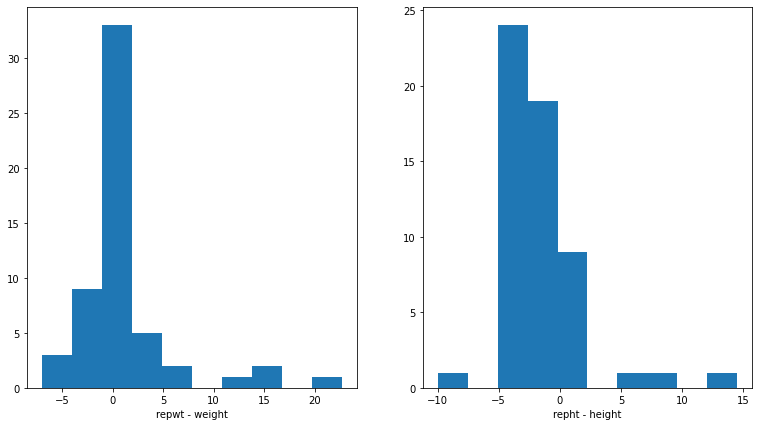

In [92]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df.where(train_davis_df["sex"]=="F")["repwt"] - train_davis_df.where(train_davis_df["sex"]=="F")["weight"])
ax[0].set_xlabel("repwt - weight")
ax[1].hist(train_davis_df.where(train_davis_df["sex"]=="F")["repht"] - train_davis_df.where(train_davis_df["sex"]=="F")["height"])
ax[1].set_xlabel("repht - height")

Генератор данных (sex, height, weight)

In [93]:
class PointGenerator:
    def __init__(self):
        self.p_woman = None
        self.p_man = None
        self.mean_height = { "woman": None, "man": None }
        self.mean_weight = { "woman": None, "man": None }
        self.cov_matrix = { "woman": None, "man": None }
         
        
    def fit(self, df):
        self.p_man = male_proportion(df) 
        self.p_woman = 1 - self.p_man
        self.mean_height["woman"] = np.mean(df.where(df["sex"] == "F")["height"])
        self.mean_height["man"] = np.mean(df.where(df["sex"] == "M")["height"])
        self.mean_weight["woman"] = np.mean(df.where(df["sex"] == "F")["weight"])
        self.mean_weight["man"] = np.mean(df.where(df["sex"] == "M")["weight"])
        self.cov_matrix["woman"] = np.cov(df[df["sex"] == "F"]["height"].to_numpy(),
                                          df[df["sex"] == "F"]["weight"].to_numpy())
        self.cov_matrix["man"] = np.cov(df[df["sex"] == "M"]["height"].to_numpy(),
                                        df[df["sex"] == "M"]["weight"].to_numpy())
        return self
    
    
    def generate_points(self, n_points):
        result = []
        for i in range(n_points):
            sex = scipy.stats.distributions.bernoulli.rvs(self.p_woman)
            if(sex == 0):
                hw = np.random.multivariate_normal(mean=[self.mean_height["man"], self.mean_weight["man"]],
                                                   cov=self.cov_matrix["man"], size=1)
                result.append(np.array([sex, hw[:, 0][0], hw[:, 1][0]]))
            else:
                hw = np.random.multivariate_normal(mean=[self.mean_height["woman"], self.mean_weight["woman"]],
                                                   cov=self.cov_matrix["woman"], size=1)
                result.append(np.array([sex, hw[:, 0][0], hw[:, 1][0]]))
        return np.array(result, dtype=float)
    
    
    def log_likehood(self, df):
        x_man = df[df["sex"] == "M"][["height", "weight"]].values
        x_woman = df[df["sex"] == "F"][["height", "weight"]].values
        
    
        result_man = self.p_man * scipy.stats.multivariate_normal.pdf(x=x_man, mean=[self.mean_height["man"], 
                                                                        self.mean_weight["man"]],
                                                                        cov=self.cov_matrix["man"])
        result_woman = self.p_woman * scipy.stats.multivariate_normal.pdf(x=x_woman, mean=[self.mean_height["woman"],
                                                                            self.mean_weight["woman"]],
                                                                            cov=self.cov_matrix["woman"])
        return np.log(np.concatenate((result_man, result_woman), axis=None))
    
    
    def mean_log_likehood(self, df):
        return self.log_likehood(df).sum() / len(df.index)

generator = PointGenerator()
generator.fit(train_davis_df)
generated_data = generator.generate_points(100)
generated_data

array([[  1.        , 157.4145044 ,  49.95534021],
       [  1.        , 165.14792527,  49.22352463],
       [  0.        , 163.02515158,  52.66759618],
       [  1.        , 168.61163001,  62.71927462],
       [  0.        , 185.8217954 ,  88.30321556],
       [  0.        , 170.05087436,  67.29210097],
       [  0.        , 169.80905426,  71.14762022],
       [  0.        , 175.84546308,  79.46876181],
       [  1.        , 168.67943945,  49.53244716],
       [  1.        , 162.05823168,  55.48132381],
       [  1.        , 183.73220975,  64.02074574],
       [  0.        , 179.41714453,  98.99733147],
       [  1.        , 171.4168779 ,  61.63233448],
       [  1.        , 163.79880766,  50.41477556],
       [  0.        , 186.99764037,  73.74026785],
       [  0.        , 165.89009672,  65.15183671],
       [  0.        , 174.48750348,  58.1686663 ],
       [  1.        , 171.42865702,  63.47004522],
       [  1.        , 169.19759279,  58.98791409],
       [  1.        , 167.69077

In [94]:
generated_df = pd.DataFrame( {"sex" : generated_data.T[0], "height" : generated_data.T[1], "weight" : generated_data.T[2]})
generated_df["sex"][generated_df["sex"] == 1] = "F"
generated_df["sex"][generated_df["sex"] == 0] = "M"
generated_df

,sex,height,weight
0,F,157.414504,49.955340
1,F,165.147925,49.223525
2,M,163.025152,52.667596
3,F,168.611630,62.719275
4,M,185.821795,88.303216
...,...,...,...
95,M,175.595081,70.896435
96,F,146.466714,52.620580
97,F,161.925667,40.696022
98,F,162.952644,48.045271


In [95]:
generator.mean_log_likehood(train_davis_df), generator.mean_log_likehood(generated_df)

(-7.308292975727253, -7.532280577686447)

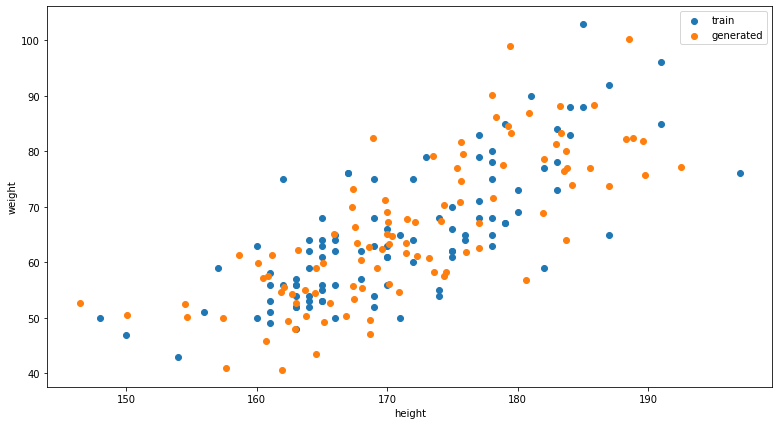

In [96]:
plt.scatter(x=train_davis_df["height"], y=train_davis_df["weight"], label="train")
plt.scatter(x=generated_data.T[1], y=generated_data.T[2], label="generated")
plt.xlabel("height")
plt.ylabel("weight")
plt.legend()

[150.0, 200.0, 40.0, 120.0, 150.0, 200.0, 40.0, 120.0]

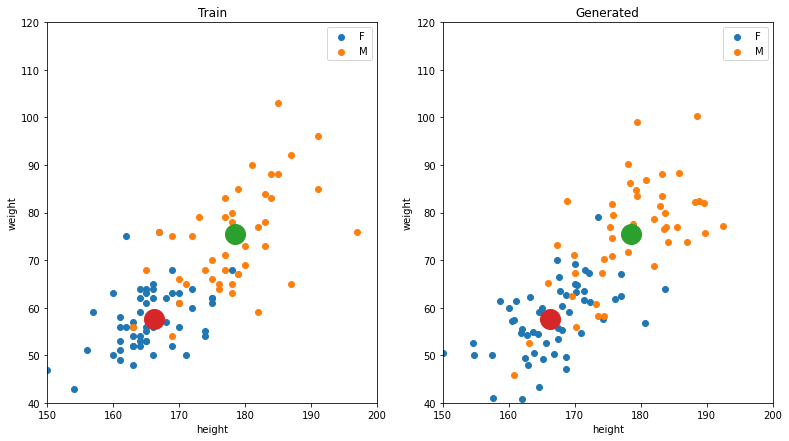

In [97]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(x=train_davis_df.where(train_davis_df["sex"] == "F")["height"],
              y=train_davis_df.where(train_davis_df["sex"] == "F")["weight"], label="F")
ax[0].scatter(x=train_davis_df.where(train_davis_df["sex"] == "M")["height"],
              y=train_davis_df.where(train_davis_df["sex"] == "M")["weight"], label="M")
ax[0].set_xlabel("height")
ax[0].set_ylabel("weight")
ax[0].set_title("Train")
ax[0].legend()
x_f = []
x_m = []
y_f = []
y_m = []
for i in range(len(generated_data)):
    if(generated_data[i][0] == 1):
        x_f.append(generated_data[i][1])
        y_f.append(generated_data[i][2])
    else:
        x_m.append(generated_data[i][1])
        y_m.append(generated_data[i][2])       
ax[1].scatter(x=x_f, y=y_f, label="F")
ax[1].scatter(x=x_m, y=y_m, label="M")
man_mean_height = np.array(x_m).mean()
woman_mean_height = np.array(x_f).mean()
man_mean_weight = np.array(y_m).mean()
woman_mean_weight = np.array(y_f).mean()
ax[0].scatter(x=man_mean_height, y=man_mean_weight, s=400)
ax[0].scatter(x=woman_mean_height, y=woman_mean_weight, s=400)
ax[1].scatter(x=man_mean_height, y=man_mean_weight, s=400)
ax[1].scatter(x=woman_mean_height, y=woman_mean_weight, s=400)
ax[1].set_xlabel("height")
ax[1].set_ylabel("weight")
ax[1].set_title("Generated")
ax[1].legend()
plt.setp(ax, xlim=(150, 200), ylim=(40, 120))

# Задание 2

Обучение градиентным спуском линейную модель

Улучшаем параметры (w1, b)

In [98]:
def param_upgrade(df, w1, b, alpha):
    x = df["height"].to_numpy()
    y = df["weight"].to_numpy()
    loss = y - w1 * x - b
    dQ_dw1 = -2 * x.dot(loss) / len(df.index)
    dQ_db = -2 * loss.mean() 
    w1 = w1 - alpha * dQ_dw1
    b = b - alpha * dQ_db
    return w1, b

param_upgrade(train_davis_df, 0, 0, 0.001)

(22.34294, 0.12976)

Среднеквадратическая ошибка

In [99]:
def rms_error(df, w1, b):
    x = df["height"].to_numpy()
    y = df["weight"].to_numpy()
    loss = y - w1 * x - b
    error = loss ** 2
    return error.mean()

Градиентный спуск

In [100]:
def gradient_descent(df, epoches_N, alpha):   
    w1 = -1
    b = -1
    w1_history = []
    b_history = []
    loss_history = []
    for i in range(epoches_N):
        w1, b = param_upgrade(df, w1, b, alpha)
        w1_history.append(w1)
        b_history.append(b)
        if i % 100 == 0:
            print(f"Loss in {i} epoch:" + str(rms_error(df, w1, b)))
        loss_history.append(rms_error(df, w1, b))
    return w1, b, w1_history, b_history, loss_history

w1, b, w1_history, b_history, loss_history = gradient_descent(train_davis_df, 10000, 1e-3)

Loss in 0 epoch:186994478.22887668
Loss in 100 epoch:inf
Loss in 200 epoch:nan
Loss in 300 epoch:nan
Loss in 400 epoch:nan


c:\users\firda\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
c:\users\firda\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in square
  """
c:\users\firda\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


Loss in 500 epoch:nan
Loss in 600 epoch:nan
Loss in 700 epoch:nan
Loss in 800 epoch:nan
Loss in 900 epoch:nan
Loss in 1000 epoch:nan
Loss in 1100 epoch:nan
Loss in 1200 epoch:nan
Loss in 1300 epoch:nan
Loss in 1400 epoch:nan
Loss in 1500 epoch:nan
Loss in 1600 epoch:nan
Loss in 1700 epoch:nan
Loss in 1800 epoch:nan
Loss in 1900 epoch:nan
Loss in 2000 epoch:nan
Loss in 2100 epoch:nan
Loss in 2200 epoch:nan
Loss in 2300 epoch:nan
Loss in 2400 epoch:nan
Loss in 2500 epoch:nan
Loss in 2600 epoch:nan
Loss in 2700 epoch:nan
Loss in 2800 epoch:nan
Loss in 2900 epoch:nan
Loss in 3000 epoch:nan
Loss in 3100 epoch:nan
Loss in 3200 epoch:nan
Loss in 3300 epoch:nan
Loss in 3400 epoch:nan
Loss in 3500 epoch:nan
Loss in 3600 epoch:nan
Loss in 3700 epoch:nan
Loss in 3800 epoch:nan
Loss in 3900 epoch:nan
Loss in 4000 epoch:nan
Loss in 4100 epoch:nan
Loss in 4200 epoch:nan
Loss in 4300 epoch:nan
Loss in 4400 epoch:nan
Loss in 4500 epoch:nan
Loss in 4600 epoch:nan
Loss in 4700 epoch:nan
Loss in 4800 epo

In [101]:
w1, b

(nan, nan)

In [102]:
for i in range(len(w1_history)):
    if i % 200 == 0:
        print(f"w1 in {i} epoch:" + str(w1_history[i]))

w1 in 0 epoch:80.27730000000001
w1 in 200 epoch:nan
w1 in 400 epoch:nan
w1 in 600 epoch:nan
w1 in 800 epoch:nan
w1 in 1000 epoch:nan
w1 in 1200 epoch:nan
w1 in 1400 epoch:nan
w1 in 1600 epoch:nan
w1 in 1800 epoch:nan
w1 in 2000 epoch:nan
w1 in 2200 epoch:nan
w1 in 2400 epoch:nan
w1 in 2600 epoch:nan
w1 in 2800 epoch:nan
w1 in 3000 epoch:nan
w1 in 3200 epoch:nan
w1 in 3400 epoch:nan
w1 in 3600 epoch:nan
w1 in 3800 epoch:nan
w1 in 4000 epoch:nan
w1 in 4200 epoch:nan
w1 in 4400 epoch:nan
w1 in 4600 epoch:nan
w1 in 4800 epoch:nan
w1 in 5000 epoch:nan
w1 in 5200 epoch:nan
w1 in 5400 epoch:nan
w1 in 5600 epoch:nan
w1 in 5800 epoch:nan
w1 in 6000 epoch:nan
w1 in 6200 epoch:nan
w1 in 6400 epoch:nan
w1 in 6600 epoch:nan
w1 in 6800 epoch:nan
w1 in 7000 epoch:nan
w1 in 7200 epoch:nan
w1 in 7400 epoch:nan
w1 in 7600 epoch:nan
w1 in 7800 epoch:nan
w1 in 8000 epoch:nan
w1 in 8200 epoch:nan
w1 in 8400 epoch:nan
w1 in 8600 epoch:nan
w1 in 8800 epoch:nan
w1 in 9000 epoch:nan
w1 in 9200 epoch:nan
w1 in 

In [103]:
for i in range(len(b_history)):
    if i % 200 == 0:
        print(f"w1 in {i} epoch:" + str(b_history[i]))

w1 in 0 epoch:-0.5264
w1 in 200 epoch:nan
w1 in 400 epoch:nan
w1 in 600 epoch:nan
w1 in 800 epoch:nan
w1 in 1000 epoch:nan
w1 in 1200 epoch:nan
w1 in 1400 epoch:nan
w1 in 1600 epoch:nan
w1 in 1800 epoch:nan
w1 in 2000 epoch:nan
w1 in 2200 epoch:nan
w1 in 2400 epoch:nan
w1 in 2600 epoch:nan
w1 in 2800 epoch:nan
w1 in 3000 epoch:nan
w1 in 3200 epoch:nan
w1 in 3400 epoch:nan
w1 in 3600 epoch:nan
w1 in 3800 epoch:nan
w1 in 4000 epoch:nan
w1 in 4200 epoch:nan
w1 in 4400 epoch:nan
w1 in 4600 epoch:nan
w1 in 4800 epoch:nan
w1 in 5000 epoch:nan
w1 in 5200 epoch:nan
w1 in 5400 epoch:nan
w1 in 5600 epoch:nan
w1 in 5800 epoch:nan
w1 in 6000 epoch:nan
w1 in 6200 epoch:nan
w1 in 6400 epoch:nan
w1 in 6600 epoch:nan
w1 in 6800 epoch:nan
w1 in 7000 epoch:nan
w1 in 7200 epoch:nan
w1 in 7400 epoch:nan
w1 in 7600 epoch:nan
w1 in 7800 epoch:nan
w1 in 8000 epoch:nan
w1 in 8200 epoch:nan
w1 in 8400 epoch:nan
w1 in 8600 epoch:nan
w1 in 8800 epoch:nan
w1 in 9000 epoch:nan
w1 in 9200 epoch:nan
w1 in 9400 epoch

Нормализация данных

In [104]:
def normalize(df):
    df = df.copy()
    df["height"] = (df["height"] - df["height"].mean()) / df["height"].std()
    df["weight"] = (df["weight"] - df["weight"].mean()) / df["weight"].std() 
    return df 
normalize(train_davis_df)

,Unnamed: 0,sex,weight,height,repwt,repht
119,120.0,M,0.009971,0.775042,66.000000,178.000000
43,44.0,M,1.090181,1.322388,80.000000,180.000000
113,114.0,M,0.176157,0.884511,67.000000,179.000000
140,141.0,M,0.093064,0.446634,68.000000,175.000000
168,169.0,M,2.585856,2.198141,95.000000,188.000000
...,...,...,...,...,...,...
33,34.0,F,-1.070239,-0.757527,52.000000,161.000000
66,67.0,F,-0.073122,-0.648057,63.000000,163.000000
166,167.0,F,-0.156215,-0.100712,62.000000,168.000000
125,126.0,F,-1.070239,-0.210181,56.000000,168.527473


In [105]:
w1, b, w1_history, b_history, loss_history = gradient_descent(normalize(train_davis_df), 10000, 0.001)

Loss in 0 epoch:4.458987182798443
Loss in 100 epoch:3.1363392647470487
Loss in 200 epoch:2.2474220503267652
Loss in 300 epoch:1.650002155936148
Loss in 400 epoch:1.2484894045888766
Loss in 500 epoch:0.97864072420141
Loss in 600 epoch:0.797280289885145
Loss in 700 epoch:0.675390848910596
Loss in 800 epoch:0.5934706665860247
Loss in 900 epoch:0.538413099142236
Loss in 1000 epoch:0.5014094622800161
Loss in 1100 epoch:0.4765396171882192
Loss in 1200 epoch:0.4598247462986588
Loss in 1300 epoch:0.4485907507834109
Loss in 1400 epoch:0.4410404068160313
Loss in 1500 epoch:0.43596582222668767
Loss in 1600 epoch:0.4325551850536081
Loss in 1700 epoch:0.43026288318097733
Loss in 1800 epoch:0.42872221413337847
Loss in 1900 epoch:0.42768671875783704
Loss in 2000 epoch:0.42699075243518697
Loss in 2100 epoch:0.4265229854798569
Loss in 2200 epoch:0.4262085930343865
Loss in 2300 epoch:0.42599728504764484
Loss in 2400 epoch:0.42585526130042994
Loss in 2500 epoch:0.4257598044142221
Loss in 2600 epoch:0.425

In [106]:
w1, b

(0.7550743292593213, -2.020286747055427e-09)

In [107]:
for i in range(len(w1_history)):
    if i % 200 == 0:
        print(f"w1 in {i} epoch:" + str(w1_history[i]))

w1 in 0 epoch:-0.9965249528194882
w1 in 200 epoch:-0.42330104296486415
w1 in 400 epoch:-0.037668926152259495
w1 in 600 epoch:0.221762208803513
w1 in 800 epoch:0.39629257297737247
w1 in 1000 epoch:0.5137065758257701
w1 in 1200 epoch:0.5926959719124616
w1 in 1400 epoch:0.6458354999310775
w1 in 1600 epoch:0.6815847216993016
w1 in 1800 epoch:0.7056347444354083
w1 in 2000 epoch:0.7218142181413602
w1 in 2200 epoch:0.732698838595734
w1 in 2400 epoch:0.7400213859535144
w1 in 2600 epoch:0.7449475751607261
w1 in 2800 epoch:0.7482616322667495
w1 in 3000 epoch:0.7504911395065252
w1 in 3200 epoch:0.7519910238999417
w1 in 3400 epoch:0.7530000599566435
w1 in 3600 epoch:0.7536788814499491
w1 in 3800 epoch:0.7541355535546916
w1 in 4000 epoch:0.754442776312524
w1 in 4200 epoch:0.7546494581351051
w1 in 4400 epoch:0.754788501792179
w1 in 4600 epoch:0.7548820423770802
w1 in 4800 epoch:0.7549449711090173
w1 in 5000 epoch:0.7549873059448257
w1 in 5200 epoch:0.755015786390367
w1 in 5400 epoch:0.75503494639802

In [108]:
for i in range(len(b_history)):
    if i % 200 == 0:
        print(f"b in {i} epoch:" + str(b_history[i]))

b in 0 epoch:-0.998
b in 200 epoch:-0.6687115105103469
b in 400 epoch:-0.4480712267425148
b in 600 epoch:-0.3002308485483078
b in 800 epoch:-0.2011701645636695
b in 1000 epoch:-0.13479439340179017
b in 1200 epoch:-0.09031920082168059
b in 1400 epoch:-0.06051852626207775
b in 1600 epoch:-0.04055053618294021
b in 1800 epoch:-0.027170952207313234
b in 2000 epoch:-0.018205940373303697
b in 2200 epoch:-0.012198919726746924
b in 2400 epoch:-0.00817390584876514
b in 2600 epoch:-0.005476938804506322
b in 2800 epoch:-0.003669831684302978
b in 3000 epoch:-0.002458976642213616
b in 3200 epoch:-0.0016476412672590617
b in 3400 epoch:-0.0011040046899881823
b in 3600 epoch:-0.0007397401241009219
b in 3800 epoch:-0.0004956640639006556
b in 4000 epoch:-0.0003321205058886975
b in 4200 epoch:-0.00022253788092636
b in 4400 epoch:-0.00014911186623271864
b in 4600 epoch:-9.991264659690795e-05
b in 4800 epoch:-6.694663008529178e-05
b in 5000 epoch:-4.4857697523176027e-05
b in 5200 epoch:-3.0056972614183834e-

In [109]:
for i in range(len(loss_history)):
    if i % 200 == 0:
        print(f"loss in {i} epoch:" + str(loss_history[i]))

loss in 0 epoch:4.458987182798443
loss in 200 epoch:2.2474220503267652
loss in 400 epoch:1.2484894045888766
loss in 600 epoch:0.797280289885145
loss in 800 epoch:0.5934706665860247
loss in 1000 epoch:0.5014094622800161
loss in 1200 epoch:0.4598247462986588
loss in 1400 epoch:0.4410404068160313
loss in 1600 epoch:0.4325551850536081
loss in 1800 epoch:0.42872221413337847
loss in 2000 epoch:0.42699075243518697
loss in 2200 epoch:0.4262085930343865
loss in 2400 epoch:0.42585526130042994
loss in 2600 epoch:0.4256956458259565
loss in 2800 epoch:0.42562353967827177
loss in 3000 epoch:0.42559096542079966
loss in 3200 epoch:0.4255762496957444
loss in 3400 epoch:0.4255696016546872
loss in 3600 epoch:0.42556659827259385
loss in 3800 epoch:0.42556524142107205
loss in 4000 epoch:0.4255646284233107
loss in 4200 epoch:0.42556435148039995
loss in 4400 epoch:0.4255642263604974
loss in 4600 epoch:0.42556416983201834
loss in 4800 epoch:0.4255641442924859
loss in 5000 epoch:0.42556413275361554
loss in 520

In [110]:
def predict(x, w1, b):
    return w1 * x + b

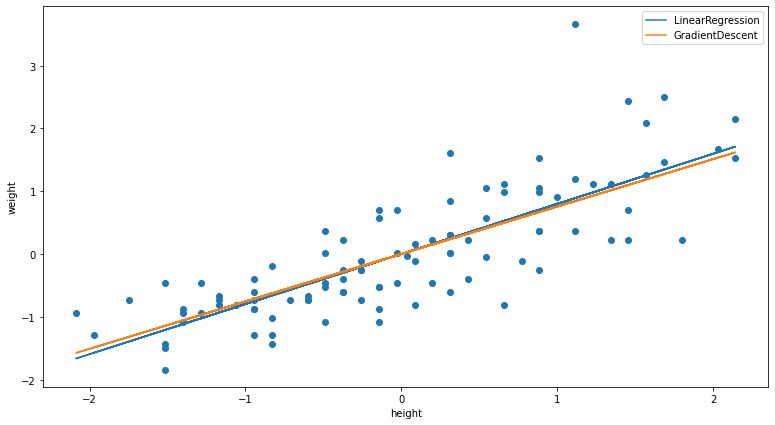

In [111]:
norm_test_df = normalize(test_davis_df)
linear_regression = LinearRegression()
x = norm_test_df["height"]
y = norm_test_df["weight"]
linear_regression.fit(x.values.reshape(-1, 1), y)
plt.plot(x, linear_regression.predict(x.values.reshape(-1, 1)), label="LinearRegression")
plt.scatter(x, y)
plt.plot(x, predict(x, w1, b), label="GradientDescent")
plt.xlabel("height")
plt.ylabel("weight")
plt.legend()

In [112]:
w1, b

(0.7550743292593213, -2.020286747055427e-09)

In [113]:
linear_regression.coef_, linear_regression.intercept_

(array([0.79778972]), 1.1082817795918432e-15)

Визуализация

Text(0, 0.5, 'w1')

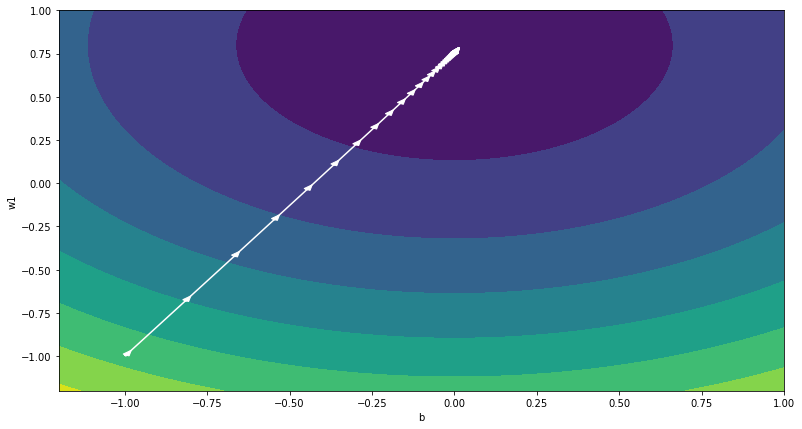

In [114]:
x = np.linspace(-1.2, 1, 100)
y = np.linspace(-1.2, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros(shape=(x.size, y.size))
for i in range(len(x)):
    for j in range(len(y)):
        loss = rms_error(norm_test_df, x[i], y[j])
        Z[i, j] = loss
plt.contourf(X, Y, Z)
plt.plot(b_history, w1_history, color="WHITE")
for i in range(len(b_history)):
    if i % 100 == 0:
        plt.arrow(b_history[i], w1_history[i], b_history[i + 1] - b_history[i], w1_history[i + 1] - w1_history[i],
                  width=0.007, color="WHITE")
plt.xlabel("b")
plt.ylabel("w1")

Обучение линейной модели градиентным спуском

In [115]:
def converter(df):
    converted_df = df.copy()
    converted_df["sex"] = (converted_df["sex"] == "M").values.astype(int)
    return converted_df

converter(train_davis_df)

,Unnamed: 0,sex,weight,height,repwt,repht
119,120.0,1,65.0,178.0,66.000000,178.000000
43,44.0,1,78.0,183.0,80.000000,180.000000
113,114.0,1,67.0,179.0,67.000000,179.000000
140,141.0,1,66.0,175.0,68.000000,175.000000
168,169.0,1,96.0,191.0,95.000000,188.000000
...,...,...,...,...,...,...
33,34.0,0,52.0,164.0,52.000000,161.000000
66,67.0,0,64.0,165.0,63.000000,163.000000
166,167.0,0,63.0,170.0,62.000000,168.000000
125,126.0,0,52.0,169.0,56.000000,168.527473


In [116]:
def param_upgrade(df, w1, w2, b, alpha):
    df = converter(df)
    x1 = df["height"].to_numpy()
    x2 = df["sex"].to_numpy()
    y = df["weight"].to_numpy()
    loss = y - w1 * x1 - w2 * x2 - b
    dQ_dw1 = -2 * x1.dot(loss) / len(df.index)
    dQ_dw2 = -2 * x2.dot(loss) / len(df.index)
    dQ_db = -2 * loss.mean()
    w1 = w1 - alpha * dQ_dw1
    w2 = w2 - alpha * dQ_dw2
    b = b - alpha * dQ_db
    return w1, w2, b

Cреднеквадратическая ошибка

In [117]:
def rms_error(df, w1, w2, b):
    df = converter(df)
    x1 = df["height"].to_numpy()
    x2 = df["sex"].to_numpy()
    y = df["weight"].to_numpy()
    loss = y - w1 * x1 - w2 * x2 - b
    error = loss ** 2
    return error.mean()

In [118]:
def predict(x1, x2, w1, w2, b):
    return w1 * x1 + w2 * x2 + b;

In [119]:
def gradient_descent_2(df, epoches_N, alpha):   
    w1 = -1
    w2 = -1
    b = -1
    w1_history = []
    w2_history = []
    b_history = []
    loss_history = []
    for i in range(epoches_N):
        w1, w2, b = param_upgrade(df, w1, w2, b, alpha)
        w1_history.append(w1)
        w2_history.append(w2)
        b_history.append(b)
        if i % 200 == 0:
            print(f"Loss in {i} epoch:" + str(rms_error(df, w1, w2, b)))
        loss_history.append(rms_error(df, w1, w2, b))
    return w1, w2, b, w1_history, w2_history, b_history, loss_history

In [120]:
w1, w2, b, w1_history, w2_history, b_history, loss_history = gradient_descent_2(normalize(train_davis_df), 10000, 0.001)

Loss in 0 epoch:7.156625591879315
Loss in 200 epoch:2.7615809029122547
Loss in 400 epoch:1.2326835996035148
Loss in 600 epoch:0.6964961268603349
Loss in 800 epoch:0.5062148872560744
Loss in 1000 epoch:0.4374035929333499
Loss in 1200 epoch:0.41168251851341864
Loss in 1400 epoch:0.40145613149150017
Loss in 1600 epoch:0.3969095687828797
Loss in 1800 epoch:0.3945076129921249
Loss in 2000 epoch:0.3929566637267262
Loss in 2200 epoch:0.3917737102903605
Loss in 2400 epoch:0.39077339811341827
Loss in 2600 epoch:0.38988166396875024
Loss in 2800 epoch:0.38906694634835043
Loss in 3000 epoch:0.38831433582700564
Loss in 3200 epoch:0.38761566718788276
Loss in 3400 epoch:0.38696563916587867
Loss in 3600 epoch:0.3863602585241719
Loss in 3800 epoch:0.3857961989942693
Loss in 4000 epoch:0.38527052789000416
Loss in 4200 epoch:0.38478058362401507
Loss in 4400 epoch:0.3843239165263777
Loss in 4600 epoch:0.38389825688582874
Loss in 4800 epoch:0.38350149508536946
Loss in 5000 epoch:0.383131667379213
Loss in 5

In [121]:
w1, w2, b

(0.5616490260965307, 0.5472893561828658, -0.23721426120282446)

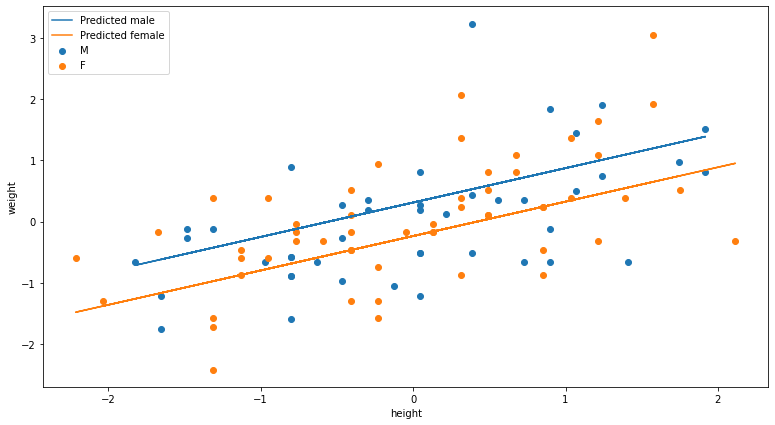

In [122]:
norm_test_df_male = normalize(test_davis_df[test_davis_df["sex"] == "M"])
norm_test_df_female = normalize(test_davis_df[test_davis_df["sex"] == "F"])
x1_male = norm_test_df_male["height"]
x1_female = norm_test_df_female["height"]
x2_male = 1
x2_female = 0
y_male = norm_test_df_male["weight"]
y_female = norm_test_df_female["weight"]
plt.scatter(x1_male, y_male, label="M")
plt.scatter(x1_female, y_female, label="F")
plt.plot(x1_male, predict(x1_male, x2_male, w1, w2, b), label="Predicted male")
plt.plot(x1_female, predict(x1_female, x2_female, w1, w2, b), label="Predicted female")
plt.xlabel("height")
plt.ylabel("weight")
plt.legend()